In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


In [55]:
# Load the CSV file
df = pd.read_csv('Dataset/Production_Data_with_Completion_Time.csv')

# Standardize column names
df.rename(columns={
    'Case ID': 'case_id',
    'Activity': 'activity',
    'Resource': 'resource',
    'Start Timestamp': 'start_timestamp',
    'Complete Timestamp': 'complete_timestamp',
    'Work Order Qty': 'work_order_qty',
    'Part Desc.': 'part_desc',
    'Worker ID': 'worker_id',
    'Report Type': 'report_type',
    'Qty Completed': 'qty_completed',
    'Qty Rejected': 'qty_rejected',
    'Qty for MRB': 'qty_for_mrb',
    'Rework': 'rework',
    'Completion Time (minutes)': 'activity_completion_time',
    'case:concept:name': 'case_concept_name',
    'concept:name': 'concept_name',
    'time:timestamp': 'time_timestamp'
}, inplace=True)

# Parse timestamps
df['start_timestamp'] = pd.to_datetime(df['start_timestamp'])
df['complete_timestamp'] = pd.to_datetime(df['complete_timestamp'])

In [56]:
# Check for missing values
print(df.isnull().sum())

case_id                     0
activity                    0
resource                    0
start_timestamp             0
complete_timestamp          0
work_order_qty              0
part_desc                   0
worker_id                   0
report_type                 0
qty_completed               0
qty_rejected                0
qty_for_mrb                 0
rework                      0
activity_completion_time    0
case_concept_name           0
concept_name                0
time_timestamp              0
dtype: int64


no missing value

Feature engoneering

In [57]:
# activity duration 
df['activity_duration'] = (df['complete_timestamp'] - df['start_timestamp']).dt.total_seconds()

In [ ]:

df['event_index'] = df.groupby('case_id').cumcount() + 1

In [59]:
df['case_start_time'] = df.groupby('case_id')['start_timestamp'].transform('min')
df['time_since_case_start'] = (df['start_timestamp'] - df['case_start_time']).dt.total_seconds()

In [60]:
df['cumulative_qty_completed'] = df.groupby('case_id')['qty_completed'].cumsum()
df['cumulative_qty_rejected'] = df.groupby('case_id')['qty_rejected'].cumsum()

In [61]:
df['rework_flag'] = df['rework'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0)

In [ ]:
le_activity = LabelEncoder()
df['activity_encoded'] = le_activity.fit_transform(df['activity'])

le_report_type = LabelEncoder()
df['report_type_encoded'] = le_report_type.fit_transform(df['report_type'])

le_part_desc = LabelEncoder()
df['part_desc_encoded'] = le_part_desc.fit_transform(df['part_desc'])

le_resource = LabelEncoder()
df['resource_encoded'] = le_resource.fit_transform(df['resource'].astype(str))

le_worker_id = LabelEncoder()
df['worker_id_encoded'] = le_worker_id.fit_transform(df['worker_id'].astype(str))

modelling

In [63]:
# Aggregate features at the case level
case_features = df.groupby('case_id').agg(
    total_activities=('activity_encoded', 'count'),
    total_activity_duration=('activity_duration', 'sum'),
    avg_activity_duration=('activity_duration', 'mean'),
    total_qty_completed=('qty_completed', 'sum'),
    total_qty_rejected=('qty_rejected', 'sum'),
    total_rework=('rework_flag', 'sum'),
    unique_activities=('activity_encoded', 'nunique'),
    work_order_qty=('work_order_qty', 'first'),
    part_desc_encoded=('part_desc_encoded', 'first'),
    report_type_encoded=('report_type_encoded', 'first'),
    resource_encoded=('resource_encoded', 'first'),
    worker_id_encoded=('worker_id_encoded', 'first')
).reset_index()

In [64]:
# ccalc start and end case time
case_times = df.groupby('case_id').agg(
    case_start_time=('start_timestamp', 'min'),
    case_end_time=('complete_timestamp', 'max')
).reset_index()

In [65]:
# calc total case time
case_times['case_completion_time'] = (
    case_times['case_end_time'] - case_times['case_start_time']
).dt.total_seconds()

In [66]:
# Merge case features and case times
case_data = case_features.merge(
    case_times[['case_id', 'case_completion_time']], on='case_id', how='left'
)

training

In [67]:
features = [
    'total_activities',
    'total_activity_duration',
    'avg_activity_duration',
    'total_qty_completed',
    'total_qty_rejected',
    'total_rework',
    'unique_activities',
    'work_order_qty',
    'part_desc_encoded',
    'report_type_encoded',
    'resource_encoded',
    'worker_id_encoded'
]

X = case_data[features]
y = case_data['case_completion_time']

In [ ]:


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)

In [ ]:

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} seconds")
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 836170.13 seconds
Root Mean Squared Error (RMSE): 1324561.92 seconds
R^2 Score: 0.54


feature imp

In [70]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                    Feature  Importance
0          total_activities    0.303967
1   total_activity_duration    0.222474
2     avg_activity_duration    0.085376
6         unique_activities    0.082027
10         resource_encoded    0.060502
3       total_qty_completed    0.055062
7            work_order_qty    0.047450
11        worker_id_encoded    0.041341
4        total_qty_rejected    0.040587
8         part_desc_encoded    0.036587
9       report_type_encoded    0.024628
5              total_rework    0.000000


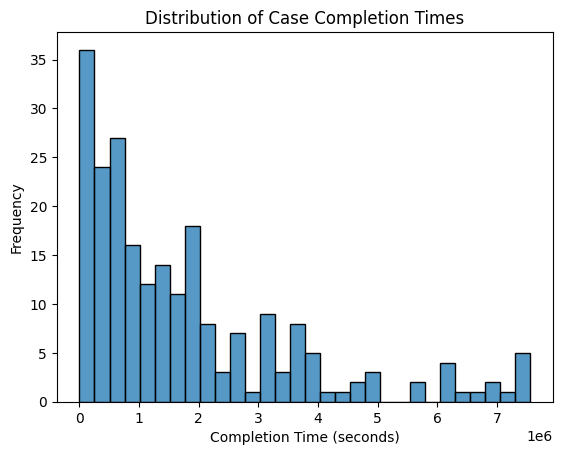

In [ ]:


sns.histplot(case_data['case_completion_time'], bins=30)
plt.title('Distribution of Case Completion Times')
plt.xlabel('Completion Time (seconds)')
plt.ylabel('Frequency')
plt.show()

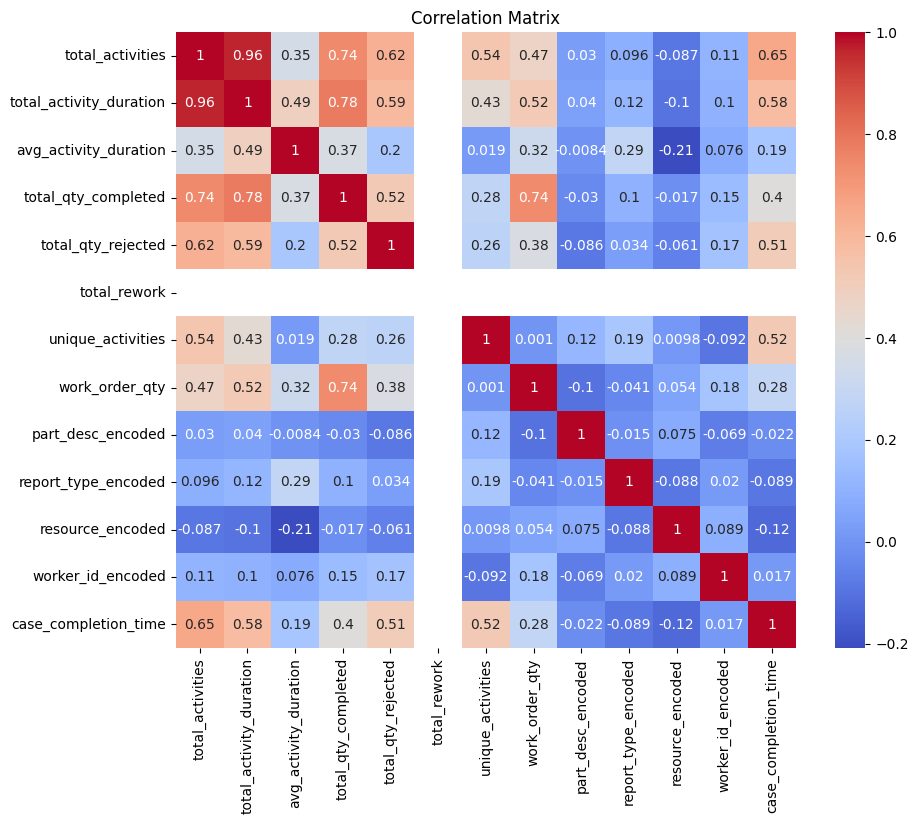

In [72]:
# Correlation matrix
corr_matrix = case_data[features + ['case_completion_time']].corr()

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [73]:
# hyper parameters tuning

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}


In [75]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Average MAE from Cross-Validation: {(-cv_scores.mean()):.2f} seconds")

Average MAE from Cross-Validation: 950271.49 seconds


this is more then normal so decline this